<a href="https://colab.research.google.com/github/MikMik1011/petnica_csgo_ai_project/blob/master/PROJEKAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math

from numba import jit, cuda

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from sklearn.model_selection import train_test_split
from datetime import datetime

!pip install python-telegram-bot

import telegram
telegrambot = telegram.Bot("5458378014:AAHbuC2qcGiUEqD02i6uWVtuE8y0xP_CzEg")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def norm(d):
    #arr = d.copy()
    for c in range(d.shape[0]):
      for i in range(d.shape[2] - 1): 
        first = d[c][0][i]
        for j in range(d.shape[1]):
          #arr[c][j][i] = d[c][j][i] - first
          d[c][j][i] -= first
    return d

def minmax(d):
    arr = d.copy()
    for f in range(d.shape[2]):
      xmax = d[:,:,f].max()
      xmin = d[:,:,f].min() 
      for i in range(d.shape[0]):
        for j in range(d.shape[1]):
          x = arr[i][j][f]
          x = (x - xmin) / (xmax - xmin)
          arr[i][j][f] = x
    return arr

In [3]:
X = np.load('/content/drive/MyDrive/PROJEKAT DATASET/X.npy')
Y = np.load('/content/drive/MyDrive/PROJEKAT DATASET/Y.npy')

In [ ]:
X = norm(X)

In [ ]:
print(X.shape)
def distribute(arr, sample_size):
  for i in range(arr.shape[0]):
    sampleCount = arr.shape[1] // sample_size
    count1 = np.empty(sampleCount)
    for s in range(sampleCount):
      firing = arr[i, s * sample_size : (s + 1) * sample_size, 4]
      count1[s] = len(firing[firing == 1])

    x_ = (1 / sampleCount) * sum(count1)
    s2 = (1 / sampleCount) * sum(pow(count1 - x_, 2))
    print(count1)
    print(x_, s2)
    


distribute(X[19:20, 58], 32)

In [ ]:
def findFiringIntervals(arr):
  mrs = []
  for i in range(arr.shape[0]):
    intervals = [0]
    lfi = -1
    for j in range(arr.shape[1]):
      if(arr[i][j][4] == 1):
        if (lfi != j - 1):
          intervals.append(0)
        intervals[-1] += 1
        lfi = j
    biggerThan1 = [k for k in intervals if k > 0] 
    
    #print(intervals)
    if(len(biggerThan1)):
      mrs.append((i, biggerThan1))
      print(i, biggerThan1)
  print(len(mrs))
findFiringIntervals(X)

In [4]:
import math

@jit(target_backend='cuda') 
def eq( a, b, eps = 0.0001 ):
  try:
    return abs( a - b ) / abs(a) <= eps
  except:
    return abs( b - a ) / abs(b) <= eps

@jit(target_backend='cuda') 
def padding(arr, step = 0.1):
  init = int(1 / step)

  for i in range(arr.shape[0]):
    for k in range(init, 0, -1):
      
      k = round(k / init, 6)
      k_man = round(k - step, 6)
    
      for j in range(arr.shape[1]):
      
        if (eq(arr[i][j][4], k)) :
          try:
            if(arr[i][j-1][4] < k_man):
              arr[i][j-1][4] = k_man
          except:
            pass

          try:
            if(arr[i][j+1][4] < k_man):
              arr[i][j+1][4] = k_man
          except:
            pass
        
  return arr

In [ ]:
padX = padding(X)
np.save('/content/drive/MyDrive/PROJEKAT DATASET/padX.npy', padX)
print(padX[0,:,4])

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7
 0.8 0.9 1.  0.9 0.8 0.7 0.6 0.5 0.6 0.7 0.8 0.9 1.  0.9 0.8 0.7 0.8 0.9
 1.  0.9 0.8 0.7 0.6 0.6 0.7 0.8 0.9 1.  0.9 0.8 0.7 0.7 0.8 0.9 1.  0.9
 0.8 0.8 0.9 1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [ ]:
X = padX

In [5]:
legitX, cheatX = np.split(X, 2)
legitY, cheatY = np.split(Y, 2)

In [6]:
ltX, leX, ltY, leY = train_test_split(legitX, legitY, test_size=0.20)
ctX, ceX, ctY, ceY = train_test_split(cheatX, cheatY, test_size=0.20)

In [ ]:
#countof1 = []
#for i in range(ltX.shape[1] // 32):
#  sga = ltX[2345,i * 32: (i + 1) * 32,4]
#  countof1.append(len(sga[sga == 1]))

from fitter import Fitter
f = Fitter(ltX[2345,:,4])
f.fit()
f.summary()

In [7]:
tX = np.concatenate((ltX, ctX))
eX = np.concatenate((leX, ceX))
tY = np.concatenate((ltY, ctY))
eY = np.concatenate((leY, ceY))

In [ ]:
from sklearn.dummy import DummyClassifier

zeror = DummyClassifier()

zeror.fit(tX, tY)
zeror.score(eX, eY)

In [ ]:
def oner(normalize = False):

    accs = []
  for br in range(tX.shape[2]):
    arX = tX[:,:,br]
    arY = np.repeat(tY, arX.shape[1])
    if (normalize):
      arX = norm(arX)
    arX = np.reshape(arX, arX.shape[0] * arX.shape[1])
    unique, unique_counts = np.unique(arX, return_counts = True)

    ar1 = {}
    ar0 = {}

    for i in range(len(arX)):
      if (arY[i] == 1):
        try:
          ar1[arX[i]] += 1
        except:
          ar1[arX[i]] = 1
      else:
          try:
            ar0[arX[i]] += 1
          except:
            ar0[arX[i]] = 1

    freq = []

    for i in unique:
      if (not ar1.get(i)):
        freq.append(ar0[i])
      elif (not ar0.get(i)):
        freq.append(ar1[i])
      else:
        freq.append(max(ar1[i], ar0[i]))

    accs.append(sum(freq) / len(arX))

  return accs

print(oner())
print(oner(normalize = True))

In [5]:
from tensorflow.keras import backend as K

def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
class CustomCallback(keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        telegrambot.send_message(text=f"Fit started", chat_id=1163033817)
      
    def on_train_end(self, logs=None):
        telegrambot.send_message(text=f"Fit ended", chat_id=1163033817)
    
    def on_epoch_end(self, epoch, logs=None):
      epoch += 1
      telegrambot.send_message(text=f"Epoch {epoch} ended \n\nTrain accuracy: {logs['binary_accuracy']} \nTrain F1-score: {logs['custom_f1']} \nTrain loss: {logs['loss']} \n\nValidation accuracy: {logs['val_binary_accuracy']} \nValidation F1-score: {logs['val_custom_f1']} \nValidation loss: {logs['val_loss']}", chat_id=1163033817)


In [ ]:
model = Sequential()
model.add(Input(shape=(192, 5)))
model.add(LSTM(200))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.BinaryFocalCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy(),
                       custom_f1,
                       keras.metrics.FalseNegatives(),
                       keras.metrics.FalsePositives()
                       ])


NameError: ignored

In [19]:
model = keras.models.load_model('/content/drive/MyDrive/MODELS/LSTM_2022-08-15_19:56', custom_objects={"custom_f1":custom_f1})

In [ ]:
ntX = norm(tX)
neX = norm(eX)

In [ ]:
rtY = tY.reshape((-1,1))
reY = eY.reshape((-1, 1))

In [ ]:
model.summary()
model.fit(tX, tY, batch_size = 25, epochs = 15, validation_data = (eX, eY), shuffle = True, use_multiprocessing = True, verbose = 1, callbacks=[CustomCallback()])
model.save("/content/drive/MyDrive/MODELS/LSTM_" + datetime.now().strftime("%Y-%m-%d_%H:%M"))
telegrambot.send_message(text=f"Model saved", chat_id=1163033817)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               164800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 56s 14ms/step - loss: 0.1745 - binary_accuracy: 0.5277 - custom_f1: 0.5054 - false_negatives_1: 22847.0000 - false_positives_1: 22492.0000 - val_loss: 0.1728 - val_binary_accuracy: 0.5339 - val_custom_f1: 0.4341 - val_false_negatives_1: 2748.0000 - val_false_positives_1: 8438.0000
Epoch 2/15
1970/3840 [==============>...............] - ETA: 23s - loss: 0.1714 - binary_accuracy: 0.5583 

KeyboardInterrupt: ignored

In [20]:
from sklearn.metrics import confusion_matrix

predY = model.predict(eX)

confMatr = confusion_matrix(eY, np.round(predY, decimals = 0) , normalize='pred')
print(confMatr)

[[0.8803348  0.11539428]
 [0.1196652  0.88460572]]


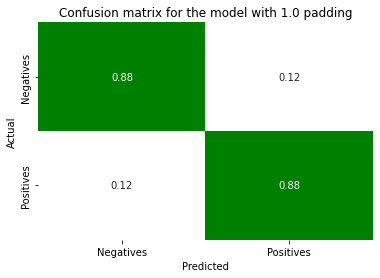

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn

seaborn.heatmap(confMatr, annot = True, cmap = ListedColormap(['white', "green"]), cbar = False, xticklabels = ["Negatives", "Positives"], yticklabels = ["Negatives", "Positives"])

padding = 1.0

plt.title(f'Confusion matrix for the model with {padding} padding')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
min(eX[:,:,3].reshape(-1))

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
dividors = [1, 2, 3, 4, 5, 7, 10, 14, 20, 25, 33, 50, 100]

for d in dividors:
  d = 1 / d
  padX = padding(X, d)

  legitX, cheatX = np.split(padX, 2)
  legitY, cheatY = np.split(Y, 2)

  ltX, leX, ltY, leY = train_test_split(legitX, legitY, test_size=0.20)
  ctX, ceX, ctY, ceY = train_test_split(cheatX, cheatY, test_size=0.20)

  tX = np.concatenate((ltX, ctX))
  eX = np.concatenate((leX, ceX))
  tY = np.concatenate((ltY, ctY))
  eY = np.concatenate((leY, ceY))

  model = Sequential()
  model.add(Input(shape=(192, 5)))
  model.add(LSTM(200))
  model.add(Dense(1, activation = "sigmoid"))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.BinaryFocalCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy(),
                       custom_f1,
                       keras.metrics.FalseNegatives(),
                       keras.metrics.FalsePositives()
                       ])

  print(f"Padding: {d}\n\n")
  telegrambot.send_message(text=f"Padding: {d}", chat_id=1163033817)
  model.summary()
  model.fit(tX, tY, batch_size = 25, epochs = 15, validation_data = (eX, eY), shuffle = True, use_multiprocessing = True, verbose = 1, callbacks=[CustomCallback()])
  model.save("/content/drive/MyDrive/MODELS/LSTM_" + datetime.now().strftime("%Y-%m-%d_%H:%M"))
  telegrambot.send_message(text=f"Model saved", chat_id=1163033817)

Padding: 1.0


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               164800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 58s 15ms/step - loss: 0.1744 - binary_accuracy: 0.5295 - custom_f1: 0.5063 - false_negatives_1: 22650.0000 - false_positives_1: 22516.0000 - val_loss: 0.1720 - val_binary_accuracy: 0.5420 - val_custom_f1: 0.3293 - val_false_negatives_1: 6030.0000 - val_false_positives_1: 4963.0000
Epoch 2/15
3840/3840 [==============================] - 59s 15ms/step - loss: 0.1710 - bina

Padding: 0.5


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               164800    
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 57s 14ms/step - loss: 0.1745 - binary_accuracy: 0.5257 - custom_f1: 0.5008 - false_negatives_2: 22651.0000 - false_positives_2: 22877.0000 - val_loss: 0.1721 - val_binary_accuracy: 0.5464 - val_custom_f1: 0.3121 - val_false_negatives_2: 6478.0000 - val_false_positives_2: 4409.0000
Epoch 2/15
3840/3840 [==============================] - 53s 14ms/step - loss: 0.1728 - bina

Padding: 0.3333333333333333


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               164800    
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 56s 14ms/step - loss: 0.1744 - binary_accuracy: 0.5293 - custom_f1: 0.5054 - false_negatives_3: 22580.0000 - false_positives_3: 22605.0000 - val_loss: 0.1725 - val_binary_accuracy: 0.5453 - val_custom_f1: 0.3753 - val_false_negatives_3: 4721.0000 - val_false_positives_3: 6191.0000
Epoch 2/15
3840/3840 [==============================] - 53s 14ms/step - loss

Padding: 0.25


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 200)               164800    
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 55s 14ms/step - loss: 0.1740 - binary_accuracy: 0.5297 - custom_f1: 0.5054 - false_negatives_4: 22921.0000 - false_positives_4: 22226.0000 - val_loss: 0.1717 - val_binary_accuracy: 0.5485 - val_custom_f1: 0.3260 - val_false_negatives_4: 6116.0000 - val_false_positives_4: 4719.0000
Epoch 2/15
3840/3840 [==============================] - 53s 14ms/step - loss: 0.1706 - bin

Padding: 0.2


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 200)               164800    
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 56s 14ms/step - loss: 0.1742 - binary_accuracy: 0.5290 - custom_f1: 0.5041 - false_negatives_5: 22562.0000 - false_positives_5: 22655.0000 - val_loss: 0.1724 - val_binary_accuracy: 0.5403 - val_custom_f1: 0.3682 - val_false_negatives_5: 4926.0000 - val_false_positives_5: 6106.0000
Epoch 2/15
3840/3840 [==============================] - 53s 14ms/step - loss: 0.1712 - bina

Padding: 0.14285714285714285


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 200)               164800    
                                                                 
 dense_6 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 56s 14ms/step - loss: 0.1744 - binary_accuracy: 0.5270 - custom_f1: 0.5019 - false_negatives_6: 22875.0000 - false_positives_6: 22537.0000 - val_loss: 0.1729 - val_binary_accuracy: 0.5428 - val_custom_f1: 0.2147 - val_false_negatives_6: 8636.0000 - val_false_positives_6: 2338.0000
Epoch 2/15
3840/3840 [==============================] - 53s 14ms/step - los

Padding: 0.1


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 200)               164800    
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 56s 14ms/step - loss: 0.1743 - binary_accuracy: 0.5306 - custom_f1: 0.5029 - false_negatives_7: 22765.0000 - false_positives_7: 22293.0000 - val_loss: 0.1712 - val_binary_accuracy: 0.5554 - val_custom_f1: 0.2684 - val_false_negatives_7: 7517.0000 - val_false_positives_7: 3153.0000
Epoch 2/15
3840/3840 [==============================] - 52s 14ms/step - loss: 0.1731 - bina

Padding: 0.07142857142857142


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 200)               164800    
                                                                 
 dense_8 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 56s 14ms/step - loss: 0.1744 - binary_accuracy: 0.5272 - custom_f1: 0.5015 - false_negatives_8: 23029.0000 - false_positives_8: 22363.0000 - val_loss: 0.1725 - val_binary_accuracy: 0.5387 - val_custom_f1: 0.3866 - val_false_negatives_8: 4365.0000 - val_false_positives_8: 6706.0000
Epoch 2/15
3840/3840 [==============================] - 53s 14ms/step - los

Padding: 0.05


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 200)               164800    
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 55s 14ms/step - loss: 0.1743 - binary_accuracy: 0.5286 - custom_f1: 0.5015 - false_negatives_9: 22841.0000 - false_positives_9: 22414.0000 - val_loss: 0.1724 - val_binary_accuracy: 0.5365 - val_custom_f1: 0.3477 - val_false_negatives_9: 5519.0000 - val_false_positives_9: 5604.0000
Epoch 2/15
3840/3840 [==============================] - 53s 14ms/step - loss: 0.1721 - bin

Padding: 0.04


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 200)               164800    
                                                                 
 dense_10 (Dense)            (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 60s 15ms/step - loss: 0.1742 - binary_accuracy: 0.5302 - custom_f1: 0.5077 - false_negatives_10: 22508.0000 - false_positives_10: 22596.0000 - val_loss: 0.1723 - val_binary_accuracy: 0.5442 - val_custom_f1: 0.2518 - val_false_negatives_10: 7875.0000 - val_false_positives_10: 3065.0000
Epoch 2/15
3840/3840 [==============================] - 53s 14ms/step - loss: 0.1711 

Padding: 0.030303030303030304


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 200)               164800    
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 55s 14ms/step - loss: 0.1742 - binary_accuracy: 0.5286 - custom_f1: 0.5018 - false_negatives_11: 22723.0000 - false_positives_11: 22527.0000 - val_loss: 0.1726 - val_binary_accuracy: 0.5417 - val_custom_f1: 0.3380 - val_false_negatives_11: 5794.0000 - val_false_positives_11: 5205.0000
Epoch 2/15
3840/3840 [==============================] - 52s 14ms/step

Padding: 0.02


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 200)               164800    
                                                                 
 dense_12 (Dense)            (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 56s 14ms/step - loss: 0.1745 - binary_accuracy: 0.5276 - custom_f1: 0.5062 - false_negatives_12: 22660.0000 - false_positives_12: 22692.0000 - val_loss: 0.1722 - val_binary_accuracy: 0.5414 - val_custom_f1: 0.4025 - val_false_negatives_12: 3853.0000 - val_false_positives_12: 7154.0000
Epoch 2/15
3840/3840 [==============================] - 54s 14ms/step - loss: 0.1717 

Padding: 0.01


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 200)               164800    
                                                                 
 dense_13 (Dense)            (None, 1)                 201       
                                                                 
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3840/3840 [==============================] - 55s 14ms/step - loss: 0.1742 - binary_accuracy: 0.5271 - custom_f1: 0.4967 - false_negatives_13: 22983.0000 - false_positives_13: 22413.0000 - val_loss: 0.1721 - val_binary_accuracy: 0.5345 - val_custom_f1: 0.3988 - val_false_negatives_13: 3981.0000 - val_false_positives_13: 7190.0000
Epoch 2/15
3840/3840 [==============================] - 58s 15ms/step - loss: 0.1727 

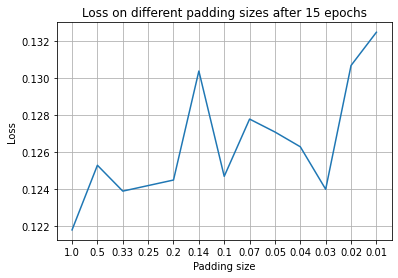

In [ ]:
import matplotlib.pyplot as plt

labels = ["1.0", "0.5", "0.33", "0.25", "0.2", "0.14", "0.1", "0.07", "0.05", "0.04", "0.03", "0.02", "0.01"]

acc = [0.7894, 0.7732, 0.7782, 0.7868, 0.7849, 0.7565, 0.7752, 0.7703, 0.7752, 0.7763, 0.7838, 0.7713, 0.7628]
f1 = [0.4401, 0.4199, 0.4189, 0.4420, 0.4280, 0.3982, 0.4323, 0.4320, 0.4305, 0.4429, 0.4283, 0.4170, 0.4366]
loss = [0.1218, 0.1253, 0.1239, 0.1242, 0.1245, 0.1304, 0.1247, 0.1278, 0.1271, 0.1263, 0.1240, 0.1307, 0.1325]
plt.plot(labels, loss)

plt.title("Loss on different padding sizes after 15 epochs")
plt.xlabel("Padding size")
plt.ylabel("Loss")
plt.grid()
plt.show()

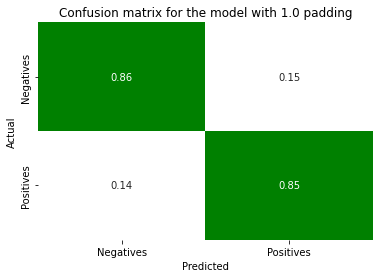

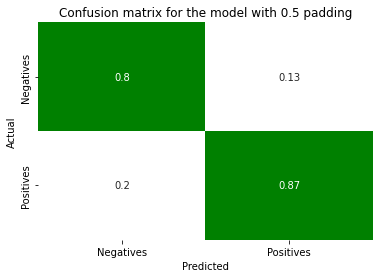

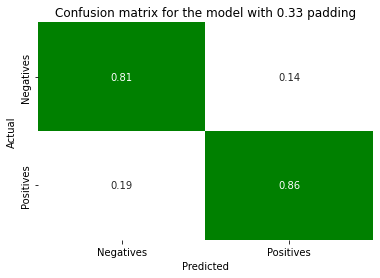

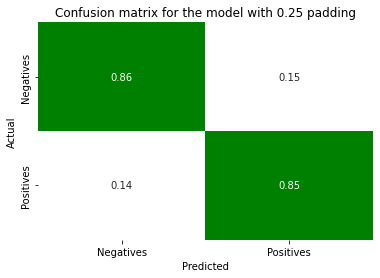

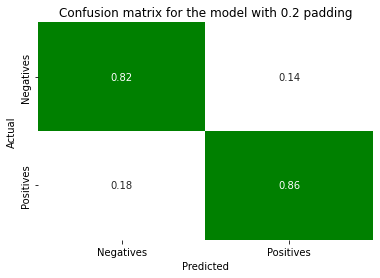

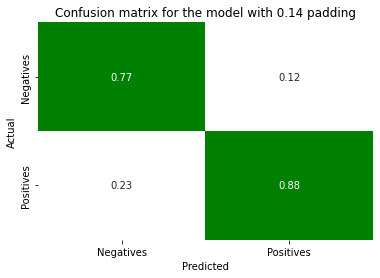

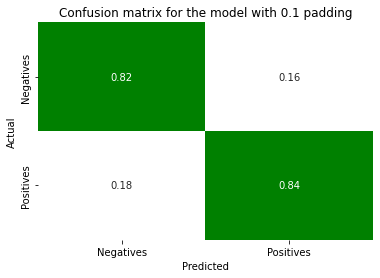

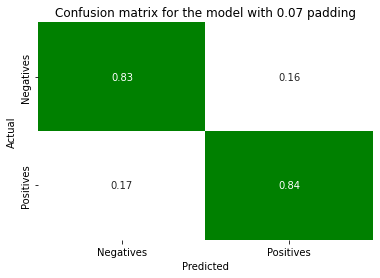

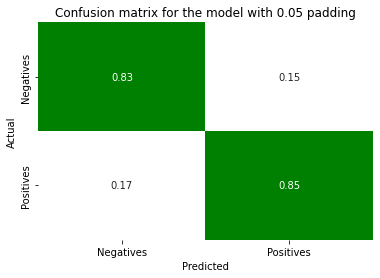

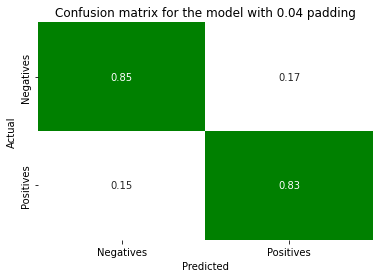

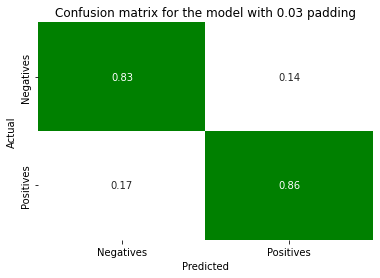

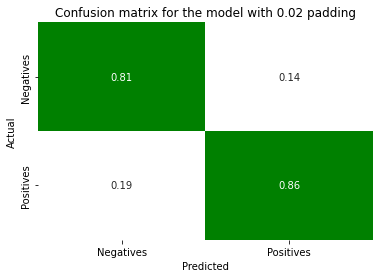

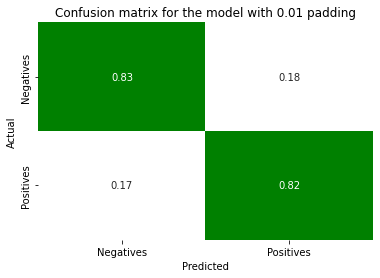

'\nfor d in dividors:\n  d = 1 / d\n  padX = padding(X, d)\n\n  legitX, cheatX = np.split(padX, 2)\n  legitY, cheatY = np.split(Y, 2)\n\n  ltX, leX, ltY, leY = train_test_split(legitX, legitY, test_size=0.20)\n  ctX, ceX, ctY, ceY = train_test_split(cheatX, cheatY, test_size=0.20)\n\n  tX = np.concatenate((ltX, ctX))\n  eX = np.concatenate((leX, ceX))\n  tY = np.concatenate((ltY, ctY))\n  eY = np.concatenate((leY, ceY))\n\n  model = Sequential()\n  model.add(Input(shape=(192, 5)))\n  model.add(LSTM(200))\n  model.add(Dense(1, activation = "sigmoid"))\n\n  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),\n              loss=keras.losses.BinaryFocalCrossentropy(),\n              metrics=[keras.metrics.BinaryAccuracy(),\n                       custom_f1,\n                       keras.metrics.FalseNegatives(),\n                       keras.metrics.FalsePositives()\n                       ])\n\n  print(f"Padding: {d}\n\n")\n  telegrambot.send_message(text=f"Padding: {d}", 

In [7]:
import os
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn

dividors = [1, 2, 3, 4, 5, 7, 10, 14, 20, 25, 33, 50, 100]

for idx, x in enumerate([i for i in next(os.walk('/content/drive/MyDrive/MODELS'))[1] if i >= "LSTM_2022-09-10"]):
    model = None
    model = keras.models.load_model(f'/content/drive/MyDrive/MODELS/{x}', custom_objects={"custom_f1":custom_f1})

    d = 1 / dividors[idx]
    padX = padding(X, d)

    legitX, cheatX = np.split(padX, 2)
    legitY, cheatY = np.split(Y, 2)

    ltX, leX, ltY, leY = train_test_split(legitX, legitY, test_size=0.20)
    ctX, ceX, ctY, ceY = train_test_split(cheatX, cheatY, test_size=0.20)

    tX = np.concatenate((ltX, ctX))
    eX = np.concatenate((leX, ceX))
    tY = np.concatenate((ltY, ctY))
    eY = np.concatenate((leY, ceY))


    predY = model.predict(eX)
    predY = predY.flatten()


    confMatr = confusion_matrix(np.where(eY > 0.5, 1, 0), np.where(predY > 0.5, 1, 0) , normalize='pred')

    seaborn.heatmap(confMatr, annot = True, cmap = ListedColormap(['white', "green"]), cbar = False, xticklabels = ["Negatives", "Positives"], yticklabels = ["Negatives", "Positives"])

    pad = round(d, 2)
    plt.title(f'Confusion matrix for the model with {pad} padding')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

"""
for d in dividors:
  d = 1 / d
  padX = padding(X, d)

  legitX, cheatX = np.split(padX, 2)
  legitY, cheatY = np.split(Y, 2)

  ltX, leX, ltY, leY = train_test_split(legitX, legitY, test_size=0.20)
  ctX, ceX, ctY, ceY = train_test_split(cheatX, cheatY, test_size=0.20)

  tX = np.concatenate((ltX, ctX))
  eX = np.concatenate((leX, ceX))
  tY = np.concatenate((ltY, ctY))
  eY = np.concatenate((leY, ceY))

  model = Sequential()
  model.add(Input(shape=(192, 5)))
  model.add(LSTM(200))
  model.add(Dense(1, activation = "sigmoid"))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.BinaryFocalCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy(),
                       custom_f1,
                       keras.metrics.FalseNegatives(),
                       keras.metrics.FalsePositives()
                       ])

  print(f"Padding: {d}\n\n")
  telegrambot.send_message(text=f"Padding: {d}", chat_id=1163033817)
  model.summary()
  model.fit(tX, tY, batch_size = 25, epochs = 15, validation_data = (eX, eY), shuffle = True, use_multiprocessing = True, verbose = 1, callbacks=[CustomCallback()])
  model.save("/content/drive/MyDrive/MODELS/LSTM_" + datetime.now().strftime("%Y-%m-%d_%H:%M"))
  telegrambot.send_message(text=f"Model saved", chat_id=1163033817)

"""